In [1]:
# System imports.
import os
import ast
import time
import random
import itertools
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit

# TensorFlow imports.
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text # To use TensorFlow Hub this import is mandatory
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from official.nlp import optimization  # to create AdamW optimizer

from modeling.scoring import span_micro_f1
from datasets.loading import TrainLoader, TestLoader

# References
https://www.tensorflow.org/text/tutorials/classify_text_with_bert#loading_models_from_tensorflow_hub

# Global configuration

In [2]:
BATCH_SIZE = 4
SEED = 42
EPOCHS = 1
SEQ_LENGTH = 512
N_LABELS = 143
DEBUG = False

tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Set reproductibility

In [3]:
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Detect hardware

In [4]:
# Detect hardware, set appropriate distribution strategy (CPU/GPU/TPU)

physical_CPU_devices = tf.config.list_physical_devices('CPU')
physical_GPU_devices = tf.config.list_physical_devices('GPU')
physical_TPU_devices = tf.config.list_physical_devices('TPU')

try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set. On Kaggle this is always the case.
    print('[INFO] Running on TPU ', TPU.master())
except:
    TPU = None
    if len(physical_GPU_devices)>0:
        print('[INFO] Running on GPU')
    else:
        print('[INFO] Running on CPU')


if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
    # enable XLA optmizations
    tf.config.optimizer.set_jit(True)
else:
    # default distribution strategy in Tensorflow.
    # Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
print(f'[INFO] REPLICAS: {REPLICAS}')

# # set half precision policy
mixed_precision.set_policy('mixed_bfloat16' if TPU else 'float32')

print('[INFO] Compute dtype: {}'.format(
    mixed_precision.global_policy().compute_dtype
))
print('[INFO] Variable dtype: {}'.format(
    mixed_precision.global_policy().variable_dtype
))

[INFO] Running on GPU
[INFO] REPLICAS: 1
[INFO] Compute dtype: float32
[INFO] Variable dtype: float32


# Data processing

#### Loading & merging

In [5]:
dl = TrainLoader()
dl.load()
dl.merge()

if DEBUG:
    dl.data = dl.data.iloc[:500, :]

dl.data

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotation_length
0,00016_000,0,16,0,[dad with recent heart attcak],[696 724],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,1
1,00016_001,0,16,1,"[mom with ""thyroid disease]",[668 693],Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...,1
2,00016_002,0,16,2,[chest pressure],[203 217],Chest-pressure,HPI: 17yo M presents with palpitations. Patien...,1
3,00016_003,0,16,3,"[intermittent episodes, episode]","[70 91, 176 183]",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...,2
4,00016_004,0,16,4,[felt as if he were going to pass out],[222 258],Lightheaded,HPI: 17yo M presents with palpitations. Patien...,1
...,...,...,...,...,...,...,...,...,...
14295,95333_912,9,95333,912,[],[],Family-history-of-migraines,Stephanie madden is a 20 year old woman compla...,0
14296,95333_913,9,95333,913,[],[],Female,Stephanie madden is a 20 year old woman compla...,0
14297,95333_914,9,95333,914,[photobia],[274 282],Photophobia,Stephanie madden is a 20 year old woman compla...,1
14298,95333_915,9,95333,915,[no sick contacts],[421 437],No-known-illness-contacts,Stephanie madden is a 20 year old woman compla...,1


#### Transform to TensorFlow

In [205]:
def create_label(df_annotation, df_history, df_annotation_length,
                 df_feature_index, tfhub_handle_preprocess, seq_length=512,
                 n_labels=143):
    """Densify location using tokenization.

    Parameters
    ----------
    df_annotation : ndarray
        Target of the task. Can be none, one or more.

    df_history : ndarray
        Text from which to extract annotation(s).

    df_annotation_length : ndarray
        Number of annotations per history.

    df_feature_index : ndarray
        Index of from features.

    tfhub_handle_preprocess : str
        Path to the TensorFlow Hub's preprocess function.

    seq_length : int, default=512
        Maximum number of words in an tokenized history.

    n_labels : int, default=143
        Number of annotation (features) classes.

    Returns
    -------
    label : Tensor
        Contains 0 if word is not part of the annotation and 1 otherwise.

    Notes
    -----
    About ~5/10mn of elapsed time. Can increase the third for loop from ~100mn
    to ~10ms using tf.math functions. WIP.

    ::
        out_2_sum = tf.math.reduce_sum(tf.cast(tf.concat([
            out_2['input_word_ids'] == tf.slice(out_1_extracted,[0, idx],[1, 1])
            for idx in range(out_1_lenght-2)
        ], axis=0), tf.int8), axis=0)
        [...]

    References
    ----------
    Procedure to change the default sequence length is from this `documentation
    <https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3>`.

    The `seq_length` variable is by default set to 512 according to `this
    notebook <https://www.kaggle.com/yasufuminakama/
    nbme-deberta-base-baseline-train?scriptVersionId=87264998&cellId=25>` where
    the max lenght was found to be 466.
    """

    # On CPU which is faster for this kind of operations
    with tf.device('/CPU:0'):

        # Load processing function
        preprocessor = hub.load(tfhub_handle_preprocess)

        # Step 1: tokenize batches of text inputs.
        text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
        tokenize = hub.KerasLayer(preprocessor.tokenize)

        # Step 3: pack input sequences for the Transformer encoder.
        bert_pack_inputs = hub.KerasLayer(
            preprocessor.bert_pack_inputs,
            arguments=dict(seq_length=seq_length)  # Optional argument.
        )

        # Fill label with 0
        # label = np.zeros(shape=(len(df_annotation), n_labels, seq_length))
        y_indices = [0] * len(df_annotation)
        y_values = [0] * len(df_annotation)

        # Loop over row in locations vector
        for row_idx in tqdm(range(len(df_annotation))):
        for row_idx in range(:len(df_annotation)):

            # Stop if there is no annotation
            if df_annotation_length[row_idx] == 0:
                y_indices[row_idx] = [[0, 0]]
                y_values[row_idx] = [0]
                continue

            # Loop over location in the current row
            history = df_history[row_idx]
            for annotation in df_annotation[row_idx]:
                out_1 = bert_pack_inputs([
                    tokenize(segment) for segment in [tf.constant([annotation])]
                ])
                out_1_lenght = tf.math.reduce_sum(out_1['input_mask'])
                out_1_extracted = tf.slice(
                    out_1['input_word_ids'], [0, 1], [1, out_1_lenght-2]
                )

                out_2 = bert_pack_inputs([
                    tokenize(segment) for segment in [tf.constant([history])]
                ])
                out_2_lenght = tf.math.reduce_sum(out_2['input_mask'])

                # This can be improved
                start_idx, idx_annotation = 0, 0
                for idx_history in range(out_2_lenght):
                    word = tf.slice(
                        out_2['input_word_ids'], [0, idx_history], [1, 1]
                    )
                    if word == tf.slice(out_1_extracted, [0, idx_annotation],
                                        [1, 1]):
                        if idx_annotation == 0:
                            start_idx = idx_history
                        idx_annotation += 1
                        if idx_annotation == out_1_lenght.numpy()-2:
                            break
                    else:
                        idx_annotation = 0

                # label[row_idx][df_feature_index[row_idx]][start_idx:start_idx+idx_annotation] = 1
                # y_row_indices = np.zeros(shape=(idx_annotation, 2), dtype=np.int32)
                # y_row_values = np.ones(shape=idx_annotation, dtype=np.int32)
                y_row_indices = [[0, 0]] * idx_annotation
                y_row_values = [0] * idx_annotation
                # y_row_indices = [0] * idx_annotation
                for k in range(idx_annotation):
                    y_row_indices[k] = [df_feature_index[row_idx], start_idx+k]
                y_indices[row_idx] = y_row_indices
                y_values[row_idx] = y_row_values
            # print(f'row_idx {row_idx:03} {y_indices[row_idx]} {df_annotation[row_idx]}')
    # label = tf.SparseTensor(indices=y_indices, values=y_values, dense_shape=[len(df_annotation), seq_length, n_labels])

    return {'indices': tf.ragged.constant(y_indices), 'values': tf.ragged.constant(y_values)}
    # return {'indices': y_indices, 'values': y_values}
    # return y_indices
    # return np.array(y_indices, dtype=object)

In [206]:
@tf.function()
def get_dense_label(x, y):
    y_indices = tf.cast(y['indices'].to_tensor(), dtype=tf.int64)
    y_values = tf.cast(y['values'], dtype=tf.int64)

    y = tf.SparseTensor(indices=y_indices, values=y_values, dense_shape=[N_LABELS, SEQ_LENGTH])
    y = tf.sparse.to_dense(y)
    y = tf.cast(y, tf.float32)

    return x, y

In [207]:
dl.data.iloc[90:92]

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotation_length
90,00188_012,0,188,12,[M],[6 7],Male,17 yo M college student comes to the clinic du...,1
91,00211_000,0,211,0,[Father MI],[682 688;695 697],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: Patient is a 17 yo m with a c/o of palpit...,1


In [208]:
train_index = np.arange(100)

y = create_label(
    dl.data['annotation'].to_numpy()[train_index],
    dl.data['pn_history'].to_numpy()[train_index],
    dl.data['annotation_length'].to_numpy()[train_index],
    dl.data['feature_text'].apply(lambda x: dl.features_to_index[x]).to_numpy()[train_index],
    tfhub_handle_preprocess,
    seq_length=SEQ_LENGTH
)
to_keep = np.array([el == [] for el in y['indices']])
to_drop = [k for k, el in enumerate(y['indices']) if el == []]
x = tf.constant(dl.data['pn_history'].to_numpy()[train_index][to_keep])
for idx in to_drop[::-1]:
    del y['indices'][idx], y['values'][idx]

train_data = tf.data.Dataset.from_tensor_slices((x, y))
train_data = train_data.map(get_dense_label, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.cache()
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
del x, y, to_drop

ValueError: Dimensions 0 and 100 are not compatible

In [ ]:
y['indices'][0, 1, 8]#[to_drop]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
for batch_x, batch_y in train_data.take(1):
    print(f'x: {batch_x.shape}')
    print(f'y: {batch_y.shape}')

x: (2,)
y: (2, 143, 512)


In [138]:
splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=SEED)
train_index, val_index = next(splitter.split(
    dl.data['pn_history'].values,
    dl.data['annotation'].values,
    groups=dl.data['pn_num'].values
))
print('[INFO] train/val: {:.2f}%/{:.2f}%'.format(
    100*len(train_index)/len(dl.data), 100*len(val_index)/len(dl.data)
))

[INFO] train/val: 69.19%/30.81%


In [167]:
print('[INFO] train data...')
x = tf.constant(dl.data['pn_history'].to_numpy()[train_index]),
y = create_label(
    dl.data['annotation'].to_numpy()[train_index],
    dl.data['pn_history'].to_numpy()[train_index],
    dl.data['annotation_length'].to_numpy()[train_index],
    dl.data['feature_text'].apply(lambda x: dl.features_to_index[x]).to_numpy()[train_index],
    tfhub_handle_preprocess,
    seq_length=SEQ_LENGTH
)
train_data = tf.data.Dataset.from_tensor_slices((x, y))
train_data = train_data.map(get_dense_label, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.cache()
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
del x, y
# 100%|██████████| 9894/9894 [02:57<00:00, 55.89it/s]

print('[INFO] validation data...')
x = tf.constant(dl.data['pn_history'].to_numpy()[val_index]),
y = create_label(
    dl.data['annotation'].to_numpy()[val_index],
    dl.data['pn_history'].to_numpy()[val_index],
    dl.data['annotation_length'].to_numpy()[val_index],
    dl.data['feature_text'].apply(lambda x: dl.features_to_index[x]).to_numpy()[val_index],
    tfhub_handle_preprocess,
    seq_length=SEQ_LENGTH
)
val_data = tf.data.Dataset.from_tensor_slices((x, y))
val_data = val_data.map(get_dense_label, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.cache()
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
del x, y

[INFO] train data...
row_idx 0 [[[0, 181], [0, 182], [0, 183], [0, 184], [0, 185], [0, 186], [0, 187]], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
row_idx 1 [[[0, 181], [0, 182], [0, 183], [0, 184], [0, 185], [0, 186], [0, 187]], [[1, 174], [1, 175], [1, 176], [1, 177], [1, 178]], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
row_idx 2 [[[0, 181], [0, 182], [0, 183], [0, 184], [0, 185], [0, 186], [0, 187]], [[1, 174], [1, 175], [1, 176], [1, 177], [1, 178]], [[2, 49], [2, 50]], 0, 0, 0, 0, 0, 

ValueError: Can't convert non-rectangular Python sequence to Tensor.

# Modelling

#### Preprocess model

Load it

In [12]:
# Load processing function
preprocessor = hub.load(tfhub_handle_preprocess)

# Step 1: tokenize batches of text inputs.
text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

# Step 3: pack input sequences for the Transformer encoder.
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=SEQ_LENGTH)  # Optional argument.
)
encoder_inputs = bert_pack_inputs(tokenized_inputs)

bert_preprocess_model = tf.keras.Model(
    text_inputs, encoder_inputs, name=f"BERT_preprocesser_{SEQ_LENGTH}"
)


Test it

In [13]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(tf.constant(text_test))

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 512)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [32]:
text_preprocessed = bert_preprocess_model(next(iter(val_data))[0])
y_preprocessed = next(iter(val_data))[1]

In [35]:
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
for k in range(2):
    print()
    # print(f'Word Ids  : {text_preprocessed["input_word_ids"][k, :]}')
    print(f'Input Mask: {text_preprocessed["input_mask"][k, :]}')
    # print(f'Type Ids  : {text_preprocessed["input_type_ids"][k, :]}')
    print(f'y value   : {y_preprocessed[k, :]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (4, 512)

Input Mask: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 

#### Bert model

Load it

In [17]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

Test it

In [15]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626282   0.9928099  -0.18611862  0.3667383   0.15233758  0.655044
  0.9681154  -0.94862705  0.0021616  -0.9877732   0.06842764 -0.97630596]
Sequence Outputs Shape:(1, 512, 512)
Sequence Outputs Values:[[-0.28946292  0.34321183  0.33231512 ...  0.21300802  0.7102092
  -0.05771042]
 [-0.28741995  0.31980985 -0.23018652 ...  0.5845511  -0.21329862
   0.72692007]
 [-0.6615692   0.68876815 -0.8743301  ...  0.1087728  -0.26173076
   0.47855455]
 ...
 [-0.22561137 -0.2892573  -0.07064426 ...  0.47566032  0.8327724
   0.40025347]
 [-0.2982421  -0.27473164 -0.05450544 ...  0.4884972   1.0955367
   0.18163365]
 [-0.4437818   0.00930662  0.07223704 ...  0.17290089  1.1833239
   0.07897975]]


#### Custom model

Build it

In [15]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(SEQ_LENGTH, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

Test it

In [16]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result.shape)

tf.Tensor(
[[0.2872575  0.46901447 0.58984905 0.5604392  0.22860773 0.51520437
  0.4371295  0.6828604  0.46950257 0.27445388 0.22564457 0.6781205
  0.34113905 0.5594853  0.35719526 0.48363426 0.15623517 0.7241221
  0.6930488  0.5279342  0.347121   0.5194836  0.6150748  0.6061924
  0.3502628  0.5516102  0.4525796  0.33552212 0.48198286 0.6022063
  0.48544875 0.391655   0.25166655 0.46566537 0.32017475 0.54694027
  0.41917458 0.2822255  0.55747175 0.76462615 0.40536186 0.6879799
  0.805211   0.5722205  0.56979746 0.60712904 0.2593401  0.5075416
  0.42908278 0.59812397 0.3372272  0.24256186 0.63527757 0.32426053
  0.36389193 0.27746117 0.7652263  0.43459615 0.37242    0.4773167
  0.4083829  0.6286806  0.55501705 0.5429083  0.29809493 0.49381876
  0.5336007  0.37991443 0.57032865 0.43633172 0.6722511  0.65141034
  0.20570482 0.57054067 0.42108992 0.42254737 0.31921488 0.49386826
  0.6053389  0.5226796  0.77811515 0.68110996 0.5408496  0.3232978
  0.38400882 0.45054793 0.40496963 0.6291871 

Display it

In [17]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 BERT_preprocesser_512 (Functio  {'input_word_ids':   0          ['text[0][0]']                   
 nal)                           (None, 512),                                                      
                                 'input_type_ids':                                                
                                (None, 512),                                                      
                                 'input_mask': (Non                                               
                                e, 512)}                                                      

#### Model compilation

In [18]:
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

Compiling BERT

In [19]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [20]:
classifier_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

#### Training

In [21]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(
    x=train_data,
    validation_data=val_data,
    epochs=EPOCHS
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
2474/2474 [==============================] - 1070s 430ms/step - loss: 13.1301 - categorical_accuracy: 0.0147 - val_loss: 12.5699 - val_categorical_accuracy: 0.0313


In [34]:
classifier_model.save('output/models/model_epoch_1')
classifier_model.save_weights('output/weights/model_epoch_1')

INFO:tensorflow:Assets written to: output/models/model_epoch_1\assets


INFO:tensorflow:Assets written to: output/models/model_epoch_1\assets


Display training

[INFO] history dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


[]

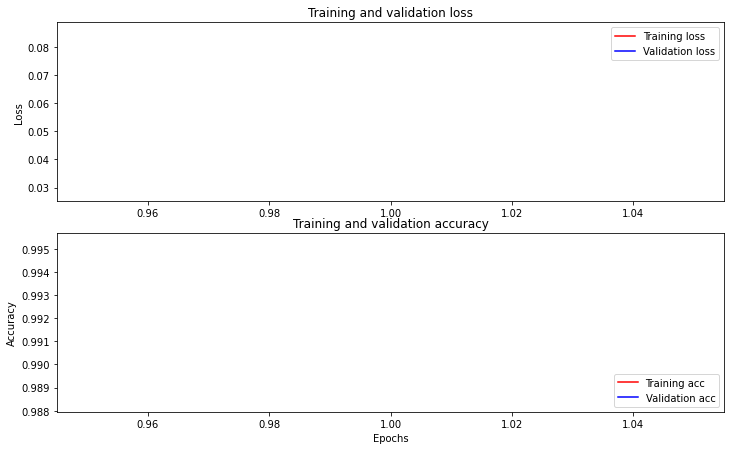

In [35]:
history_dict = history.history
print('[INFO] history', history_dict.keys())

epochs = range(1, len(history_dict['loss']) + 1)
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
fig.tight_layout()

axs[0].plot(epochs, history_dict['loss'], 'r', label='Training loss')
axs[0].plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, history_dict['binary_accuracy'], 'r', label='Training acc')
axs[1].plot(epochs, history_dict['val_binary_accuracy'], 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')

plt.plot()

In [22]:
def create_labels_for_scoring(df):
    # example: ['0 1', '3 4'] -> ['0 1; 3 4']
    df['location_for_create_labels'] = [ast.literal_eval(f'[]')] * len(df)
    for i in range(len(df)):
        lst = df.loc[i, 'location']
        if lst:
            new_lst = ';'.join(lst)
            df.loc[i, 'location_for_create_labels'] = ast.literal_eval(f'[["{new_lst}"]]')
    # create labels
    truths = []
    for location_list in df['location_for_create_labels'].values:
        truth = []
        if len(location_list) > 0:
            location = location_list[0]
            for loc in [s.split() for s in location.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                truth.append([start, end])
        truths.append(truth)
    return truths

In [23]:
def get_result(predictions, threshold=0.5):
    results = []
    for pred in predictions:
        result = np.where(pred >= threshold)[0] + 1
        result = [
            list(g) for _, g in itertools.groupby(
                result, key=lambda n, c=itertools.count(): n - next(c)
            )
        ]
        result = [f"{min(r)} {max(r)}" for r in result]
        result = ";".join(result)
        results.append(result)
    return results

In [24]:
def get_predictions(results):
    predictions = []
    for result in results:
        prediction = []
        if result != "":
            for loc in [s.split() for s in result.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                prediction.append([start, end])
        predictions.append(prediction)
    return predictions

In [25]:
df = dl.data.copy()
truths = create_labels_for_scoring(df)
prediction = tf.sigmoid(classifier_model.predict(val_data, verbose=1))

1102/1102 [==============================] - 127s 115ms/step


In [28]:
best_th = 0.5
best_score = 0.
for th in np.arange(0.4, 0.6, 0.01):
    #th = np.round(th, )
    results = get_result(prediction, threshold=th)
    preds = get_predictions(results)
    score = span_micro_f1(preds, truths)
    if best_score < score:
        best_th = th
        best_score = score
    print(f"th: {th}  score: {score:.5f}")
print(f"best_th: {best_th}  score: {best_score:.5f}")

th: 0.4  score: 0.04905
th: 0.41000000000000003  score: 0.04917
th: 0.42000000000000004  score: 0.04926
th: 0.43000000000000005  score: 0.04931
th: 0.44000000000000006  score: 0.04932
th: 0.45000000000000007  score: 0.04938
th: 0.4600000000000001  score: 0.04953
th: 0.4700000000000001  score: 0.04953
th: 0.4800000000000001  score: 0.04954
th: 0.4900000000000001  score: 0.04956
th: 0.5000000000000001  score: 0.04957
th: 0.5100000000000001  score: 0.04957
th: 0.5200000000000001  score: 0.04965
th: 0.5300000000000001  score: 0.04965
th: 0.5400000000000001  score: 0.04974
th: 0.5500000000000002  score: 0.04973
th: 0.5600000000000002  score: 0.04973
th: 0.5700000000000002  score: 0.04977
th: 0.5800000000000002  score: 0.04986
th: 0.5900000000000002  score: 0.04991
best_th: 0.5900000000000002  score: 0.04991
